# Questão 5.11
Write a program implementing the three-layer MLP with BP rule, incorporating the weight-decaying function.

- (a) Generate 200 points $y = \phi(x_1 + 2x_2) + 0.5(x_1 - x_2)^2 + 0.5N$, where $\phi(\cdot)$ is the logistic sigmoidal function, and $N$ is a number drawn from the standard normal distribution. Apply the program on the samples.
- (b) Test the program using 1000 randomly generated samples.
- (c) Plot the training and testing errors versus the number of training epochs for differing weight-decay parameters.
- (d) Describe the overfitting phenomenon observed.

**RESOLUÇÃO**:

 (a) Generate 200 points $y = \phi(x_1 + 2x_2) + 0.5(x_1 - x_2)^2 + 0.5N$, where $\phi(\cdot)$ is the logistic sigmoidal function, and $N$ is a number drawn from the standard normal distribution. Apply the program on the samples.

A questão pede uma rede neural de 3 camadas (sendo uma delas camada escondida), fazendo uso de Backpropagation (BP) e incorporando a weight-decaying function (Regularização L2). 

O programa será executado para o conjunto de treino e, em seguida, testado no conjunto de teste, por conveniência. 

Importando a função logística e o NumPy:

In [1]:
# Import libraries
from scipy.stats import logistic
import numpy as np
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import math
# Numpy random seed
np.random.seed(seed=10) 


## Plot da função

Primeiramente, geramos pontos uniformemente distribuídos no espaço para fazer um gráfico 3D, aplicando a função $y=f(x)$ nos pontos $(x_1,x_2)$, para que possamos visualizar a função. Variamos os pontos de forma que $-5\leq x_1, x_2\leq5$

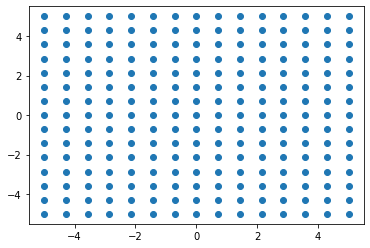

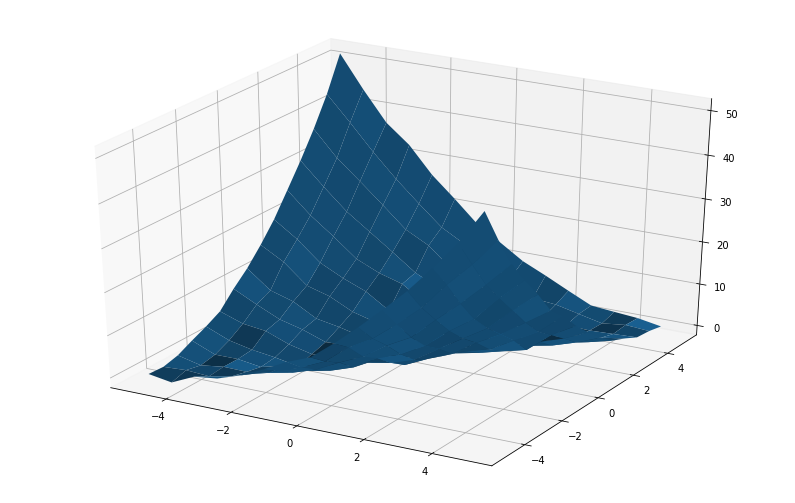

In [3]:
# Gerando os dados
N_sqrt = 15
x_graph1 = np.outer(np.linspace(-5, 5, N_sqrt), np.ones(N_sqrt))
x_graph2 = x_graph1.copy().T # transpose
n = np.random.randn(N_sqrt,N_sqrt)
f = logistic.cdf(x_graph1 + 2*x_graph2) + 0.5*(x_graph1 - x_graph2) ** 2 + 0.5*n 


#Visualizando os dados
plt.scatter(x_graph1,x_graph2)
plt.show()

# Criando a figura 3D
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Criando o Plot
ax.plot_surface(x_graph1,x_graph2,f)
 
# Mostrando o Plot
plt.show()


Podemos ver então o formato da função $y=f(x)$.

##Construindo os conjuntos de Treino e Teste

Definindo a função $\phi(\cdot)$ usando a sigmóide logística:

In [4]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
def y_function(x1,x2):
  return sigmoid(x1 + 2*x2) + 0.5*(x1 - x2) ** 2 + 0.5*np.random.randn() 

Definindo a função ReLu:

In [5]:
def relu(x):
  return max(0,x)

Aqui são definidos os vetores $x_1$ e $x_2$ com 200 valores gerados, um $n$ da distribuição normal padrão e as matrizes que serão utilizadas de modo que $-5\leq x_1, x_2 \leq 5$. 

Os pontos do conjunto de treino são gerados utilizando uma distribuição uniforme, para que se tenha pontos distribuídos uniformemente em um retângulo.

Como o formato dos dados que a MLP recebe como entrada é diferente do formato utilizado para gerar o Plot3D anterior, temos que gerar o conjunto de novo.



200


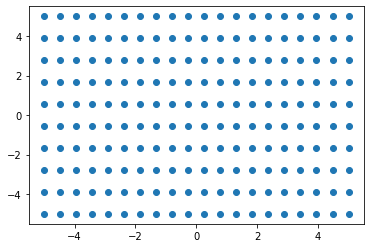

In [6]:
#N = Número de Elementos no conjunto de Treino
#N1 é o número de pontos no eixo de x1 
#N2 o número de pontos no eixo de x2, N= N1*N2
N = 200
NX1 = 20
NX2 = 10
# Gerando o conjunto de treino, de forma que tenhamos uma distribuição uniforme:

x1 = np.linspace(-5, 5, 20)
x2 = np.linspace(-5, 5, 10)
x_treino = []
for i in range(NX1):
  for j in range(NX2):
    x_treino.append([x1[i], x2[j]])
x_treino = np.array(x_treino)


#Aplicando a função no nosso x_treino para termos o y de treino:
y_treino = np.array([ y_function(x[0],x[1]) for x in x_treino])



#Visualizing dataset
print(np.size(x_treino.T[0]))
plt.scatter(x_treino.T[0],x_treino.T[1])
plt.show()



Agora geramos o conjunto de teste de forma randômica, diferente do conjunto de treino. Além disso, geramos o conjunto de teste com $-7 \leq x1, x2 \leq 7$ para ter um conjunto que tenha mais diferenças em relação ao conjunto de treino.

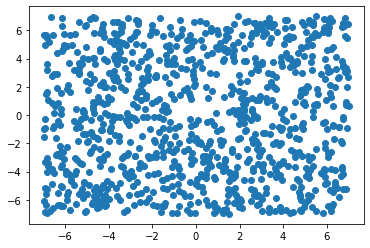

In [7]:
#Número de Elementos no conjunto de Teste
Nt = 1000

# Definição do conjunto de treino
#x_test = np.random.normal(0,1,(1000,2))
def y_function_test(x1,x2):
  return sigmoid(x1 + 2*x2) + 0.5*(x1 - x2) ** 2 + 0.5*np.random.randn() 

x_test = 14 * np.random.random_sample((1000, 2)) - 7
#y_test = np.array([ y_function(x[0],x[1]) for x in x_test])
y_test = np.array([ y_function_test(x[0],x[1]) for x in x_test])
#Visualizing dataset
plt.scatter(x_test.T[0], x_test.T[1])
plt.show()


##Realizando o Treinamento

Utilizamos a função MLPRegressor do sklearn. Utilizamos o solver = adam, que é o solver padrão do sklearn

In [8]:
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error

A função run_experimente tem como argumentos: o learning_rate, o número máximo de épocas e o parâmetro de weight-decay. A função retorna: um array de training e test losses, para plotarmos o gráfico das losses versus as épocas.
O min_loss_test_index guarda qual foi a época de menor loss de teste. O pred_treino e pred_test são o output da MLP, para prever o resultado, usando o dataset de treino e teste. Fixamos nossa MLP em 10 camadas

In [10]:
#Fixamos aqui o início do nosso range de épocas
inicio_range = 10
#Fixamos aqui os steps no nosso range de épocas
steps_range = 5

#Coloquei um ignore_warning para ele não avisar que não convergiu ainda
@ignore_warnings(category=ConvergenceWarning)
def run_MLP(cons_learning_rate, max_epochs, L2_Parameter):
  #Criamos o nosso array de épocas
  maxiter_list = range(inicio_range,max_epochs,steps_range)
  #Criamos o array dos training_losses e test_losses
  training_losses = []
  test_losses = []
  min_loss_test_index = 0
  min_loss_test= 9000000
  #Iteramos sobre as épocas máximas possíveis
  for m  in maxiter_list:
    mlp = MLPRegressor( hidden_layer_sizes = [10], max_iter=m, learning_rate_init = cons_learning_rate, random_state = 10, alpha= L2_Parameter)
    mlp.fit(x_treino, y_treino)
    
    train_pred = mlp.predict(x_treino)
    loss_train = mean_squared_error(y_true = y_treino, y_pred = train_pred)
    training_losses.append(loss_train)

    test_pred = mlp.predict(x_test)
    loss_test = mean_squared_error(y_true = y_test, y_pred = test_pred)
    if(loss_test<min_loss_test):
      min_loss_test = loss_test
      min_loss_test_index = m
    test_losses.append(loss_test)

  pred_treino = mlp.predict(x_treino)
  pred_test = mlp.predict(x_test)
  return [training_losses, test_losses, min_loss_test_index, pred_treino, pred_test]

## Imprimindo resultados

Aqui definimos as funções que nos permitem imprimir a função $y=f(x)$ aproximada pela MLP e também a função que nos permite imprimir os erros ao longo das épocas.

In [19]:
def imprimir_erros(maxiter_list, training_losses, test_losses):
  fig = plt.figure(figsize =(14, 9))
  plt.plot(maxiter_list, training_losses)
  plt.plot(maxiter_list, test_losses,  color='green')
  plt.ylabel('Training and Test Loss')
  fig.suptitle('MSE x Epochs', fontsize=20)

  plt.xlabel('Epochs', fontsize=18)
  plt.ylabel('Mean Squared Error(MSE)', fontsize=16)

  plt.show()

In [14]:
# %matplotlib widget
import pandas as pd
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D


def imprimir_funcao_predict_3D(x_, pred_):
  # Creating dataset
  x1_ = np.outer(x_[:,0],np.ones(x_.shape[0]))#np.outer(np.linspace(-10, 10, samples), np.ones(samples))
  x2_ = np.outer(x_[:,1],np.ones(x_.shape[0]))#x1.copy().T
  out_data = np.append(x_,pred_.reshape(len(pred_), 1),axis=1)
  df = pd.DataFrame(out_data,columns=['x1', 'x2', 'y'])

  # 2D-arrays from DataFrame
  x1 = np.linspace(df['x1'].min(), df['x1'].max(), len(df['x1'].unique()))
  y1 = np.linspace(df['x2'].min(), df['x2'].max(), len(df['x2'].unique()))

  """
  x, y via meshgrid for vectorized evaluation of
  2 scalar/vector fields over 2-D grids, given
  one-dimensional coordinate arrays x1, x2,..., xn.
  """

  x2, y2 = np.meshgrid(x1, y1)

  # Interpolate unstructured D-dimensional data.
  z2 = griddata((df['x1'], df['x2']), df['y'], (x2, y2), method='cubic')

  # Ready to plot
  fig = plt.figure(figsize =(14, 9))
  ax = fig.gca(projection='3d')
  surf = ax.plot_surface(x2, y2, z2)
  #ax.set_zlim(-1.01, 1.01)

  ax.zaxis.set_major_locator(LinearLocator(10))
  ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

  ax.set_xlabel('$X1$', fontsize=20)
  ax.set_ylabel('$X2$', fontsize=20)
  ax.set_zlabel(r'$Y$', fontsize=30)

  #fig.colorbar(surf, shrink=0.5, aspect=5)
  plt.title('Função y aproximada pela rede',fontsize=40)

  plt.show()

## a) e b) Resultado da aplicação da MLP no conjunto de treino e teste

De início fixamos a taxa de aprendizado em 0.5 e o parâmetro de weight-decay (regularização) em 0.0001

In [15]:
training_losses, test_losses,min_loss_test_index, pred_treino, pred_test =  run_MLP(cons_learning_rate=0.5, max_epochs = 500,L2_Parameter= 0.0001)
maxiter_list = range(inicio_range,500,steps_range)

Imprimindo a função aproximada para o conjunto de treino

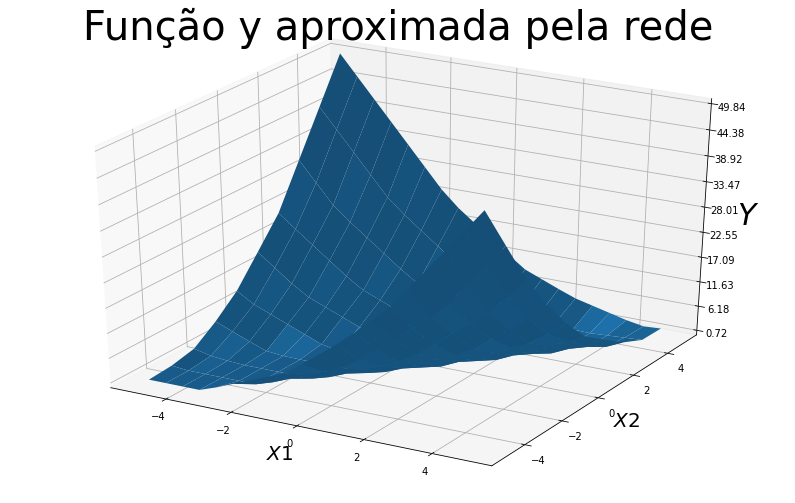

In [16]:
imprimir_funcao_predict_3D(x_treino, pred_treino)

Imprimindo a função aproximada para o conjunto de teste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Z contains NaN values. This may result in rendering artifacts.


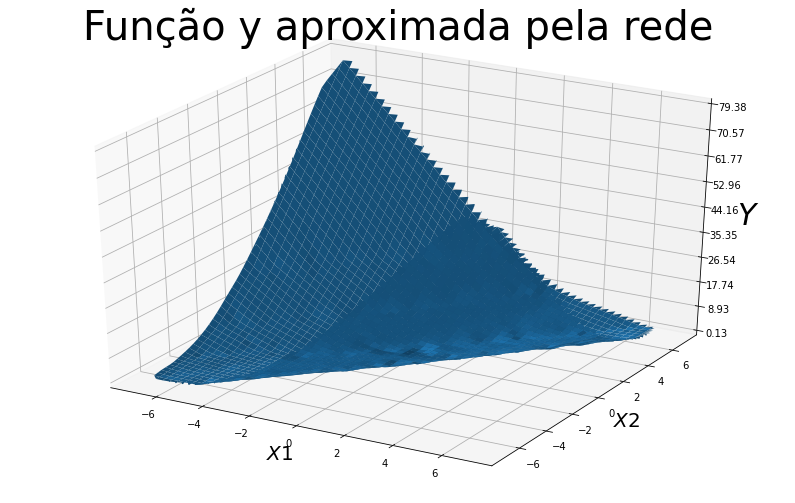

In [17]:
imprimir_funcao_predict_3D(x_test, pred_test)

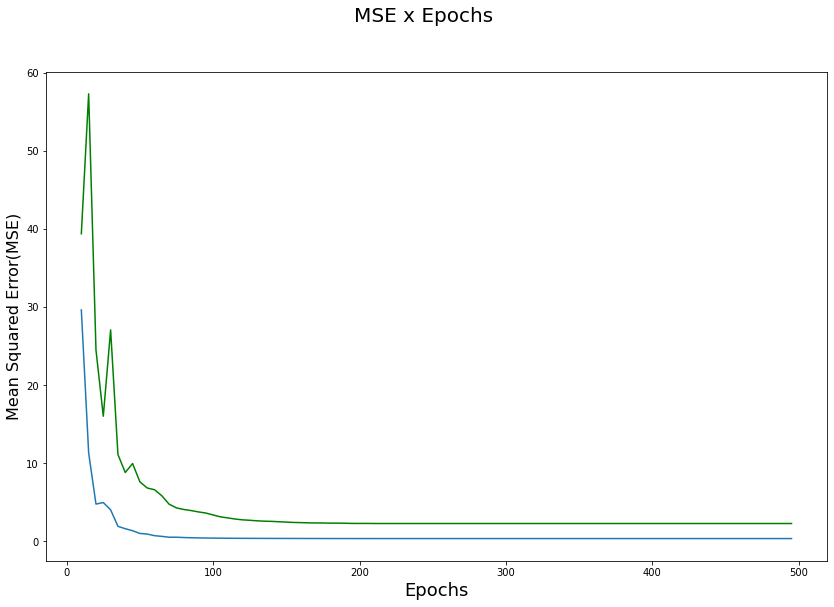

In [20]:
imprimir_erros(maxiter_list, training_losses, test_losses)

Vemos que as funções que foram plotadas são semelhantes à função desejada, que foi mostrada no início desse notebook.

## c) e d) Variando os parâmetros de decaimento e verificando se há overfitting

Nessa seção, tentamos variar o parâmetro do weight-decay (regularização) para ver a diferença nos gráficos do Mean Squared Error (MSE). Além do gráfico nós vemos em que ponto a função loss atinge o mínimo. Nesse caso, ele pega o primeiro ponto em que atinge o mínimo, então nos pontos subsequentes nós temos apenas estabilidade. Também imprimimos no ponto mínimo e no fim, para comparar e verificar se houve crescimento ou estabilidade. Em seguida analisamos se há o fenômeno de overfitting.

Fizamos o número máximo de épocas para todos esses experimentos

In [21]:
limite_epocas=500

### Parameter = 0 (Sem regularização)

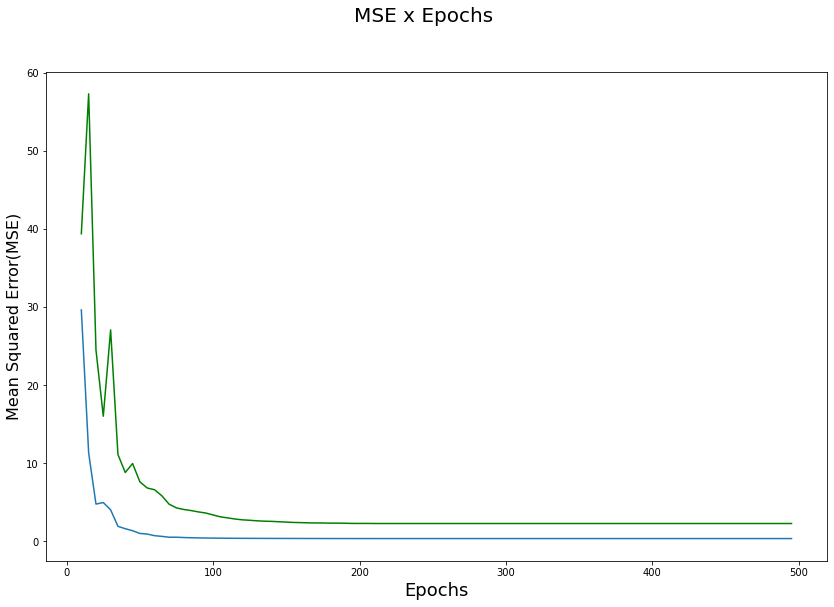

Época com o primeiro menor loss:  210


In [25]:
training_losses, test_losses,min_loss_test_index, pred_treino, pred_test =  run_MLP(cons_learning_rate=0.5, max_epochs = limite_epocas,L2_Parameter= 0.0001)
maxiter_list = range(inicio_range,500,steps_range)
imprimir_erros(maxiter_list, training_losses, test_losses)
print("Época com o primeiro menor loss: ", min_loss_test_index)


In [26]:
aux = int((min_loss_test_index-10)/5)
print("MSE no mínimo", training_losses[aux])
aux = int((495-10)/5)
print("MSE no fim", training_losses[aux])

MSE no mínimo 0.34491801326599036
MSE no fim 0.34491801326599036


### Parameter = 0.0001

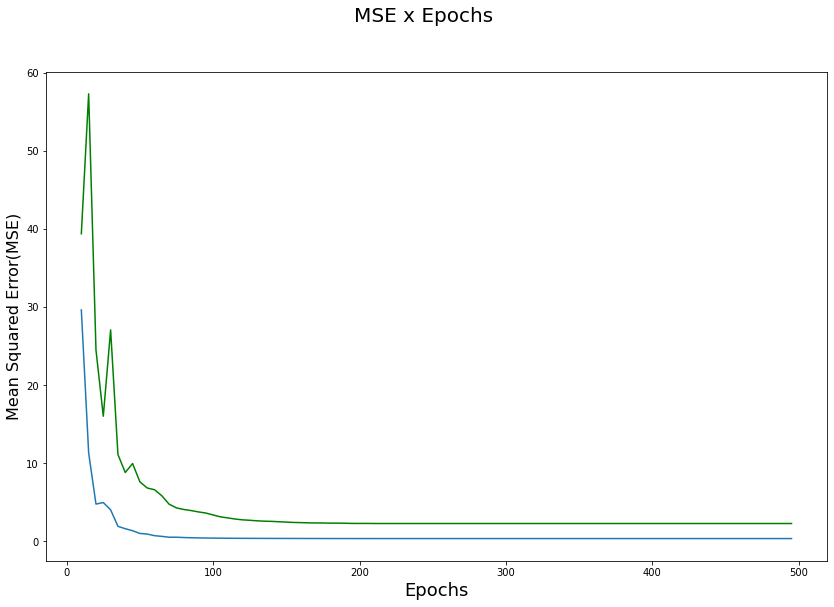

Época com o primeiro menor loss:  210


In [28]:
training_losses, test_losses,min_loss_test_index, pred_treino, pred_test =  run_MLP(cons_learning_rate=0.5, max_epochs = limite_epocas,L2_Parameter= 0.0001)
maxiter_list = range(inicio_range,500,steps_range)
imprimir_erros(maxiter_list, training_losses, test_losses)
print("Época com o primeiro menor loss: ", min_loss_test_index)

In [29]:
aux = int((min_loss_test_index-10)/5)
print("MSE no mínimo", training_losses[aux])
aux = int((495-10)/5)
print("MSE no fim", training_losses[aux])

MSE no mínimo 0.34491801326599036
MSE no fim 0.34491801326599036


### Parameter = 0.001

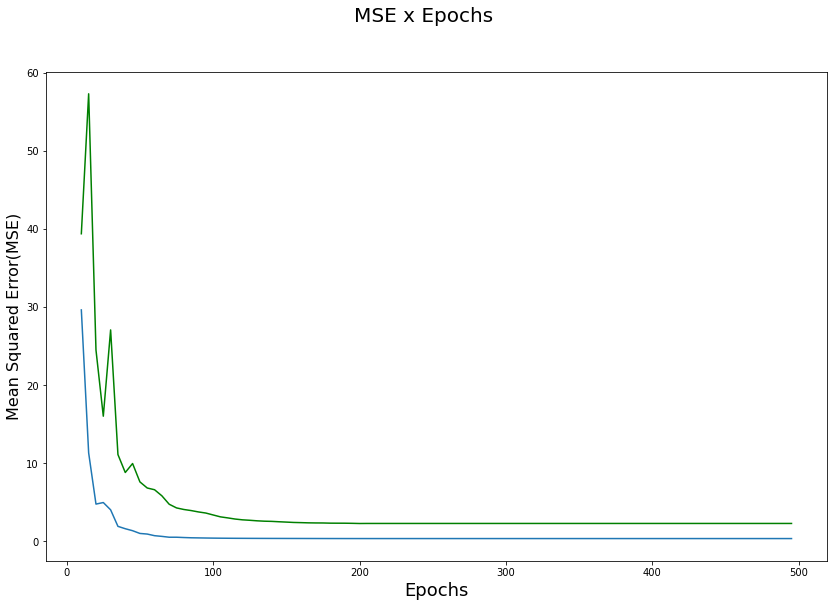

Época com o primeiro menor loss:  200


In [30]:
training_losses, test_losses,min_loss_test_index, pred_treino, pred_test =  run_MLP(cons_learning_rate=0.5, max_epochs = limite_epocas,L2_Parameter= 0.001)
maxiter_list = range(inicio_range,500,steps_range)
imprimir_erros(maxiter_list, training_losses, test_losses)
print("Época com o primeiro menor loss: ", min_loss_test_index)

In [31]:
aux = int((min_loss_test_index-10)/5)
print("MSE no mínimo", training_losses[aux])
aux = int((495-10)/5)
print("MSE no fim", training_losses[aux])

MSE no mínimo 0.3456888656998939
MSE no fim 0.34538065700724657


### Parameter = 0.01

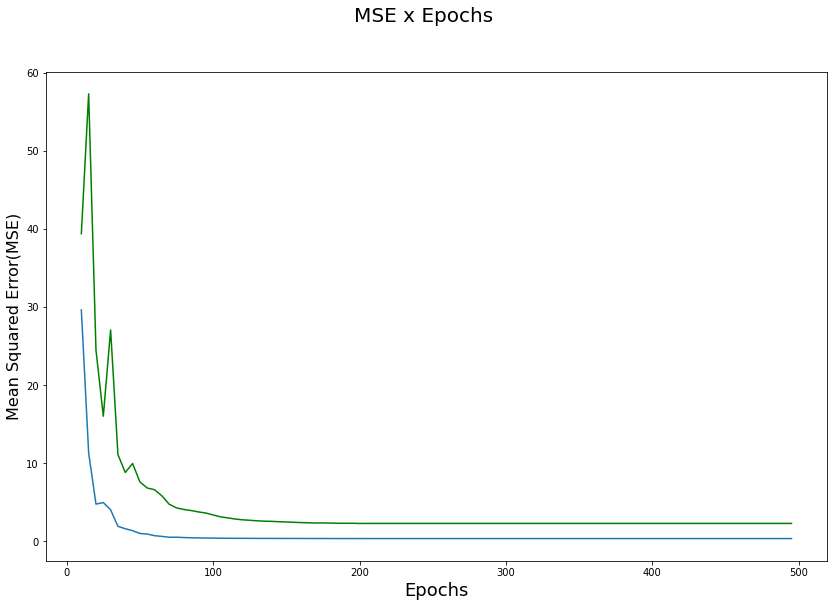

Época com o primeiro menor loss:  200


In [32]:
training_losses, test_losses,min_loss_test_index, pred_treino, pred_test =  run_MLP(cons_learning_rate=0.5, max_epochs = limite_epocas,L2_Parameter= 0.01)
maxiter_list = range(inicio_range,500,steps_range)
imprimir_erros(maxiter_list, training_losses, test_losses)
print("Época com o primeiro menor loss: ", min_loss_test_index)

In [33]:
aux = int((min_loss_test_index-10)/5)
print("MSE no mínimo", training_losses[aux])
aux = int((495-10)/5)
print("MSE no fim", training_losses[aux])

MSE no mínimo 0.3457728275108606
MSE no fim 0.3455477112145438


### Parameter = 0.1

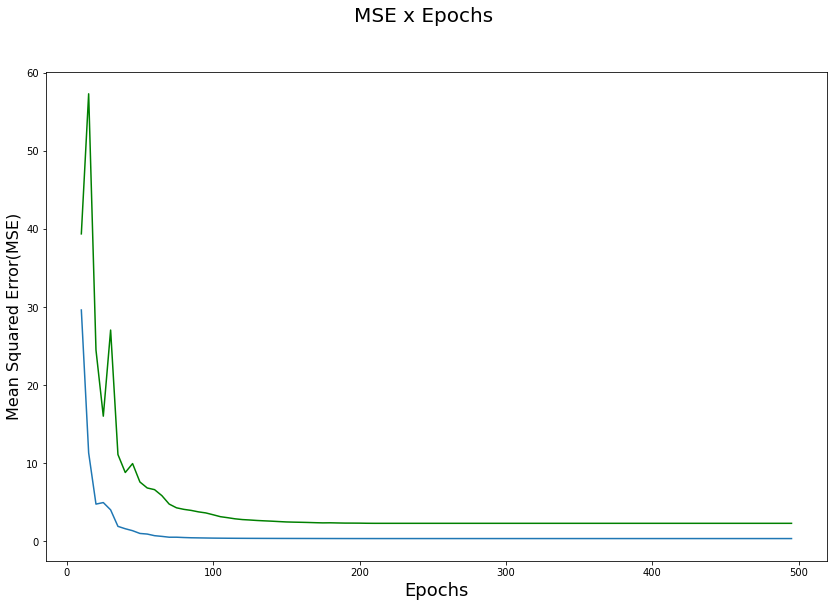

Época com o primeiro menor loss:  210


In [34]:
training_losses, test_losses,min_loss_test_index, pred_treino, pred_test =  run_MLP(cons_learning_rate=0.5, max_epochs = limite_epocas,L2_Parameter= 0.1)
maxiter_list = range(inicio_range,500,steps_range)
imprimir_erros(maxiter_list, training_losses, test_losses)
print("Época com o primeiro menor loss: ", min_loss_test_index)

In [35]:
aux = int((min_loss_test_index-10)/5)
print("MSE no mínimo", training_losses[aux])
aux = int((495-10)/5)
print("MSE no fim", training_losses[aux])

MSE no mínimo 0.3449176718923019
MSE no fim 0.3449176718923019


Vemos que as curvas não mudaram muito com a variação dos parâmetros, permanecendo bem semelhantes.

Além disso, não observamos um overfitting muito claro, o que se observa é que a MSE alcança um mínimo e depois a função estabiliza, então não observamos o overfitting. Acreditamos que isso acontece pela semelhança entre as formas com que os dados de treino e teste são gerados.